In [191]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D
import seaborn as sns

In [192]:
%config InlineBackend.figure_format = "retina"

In [193]:
color = "#5A5A5A"

In [194]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

sns.set_palette("colorblind")

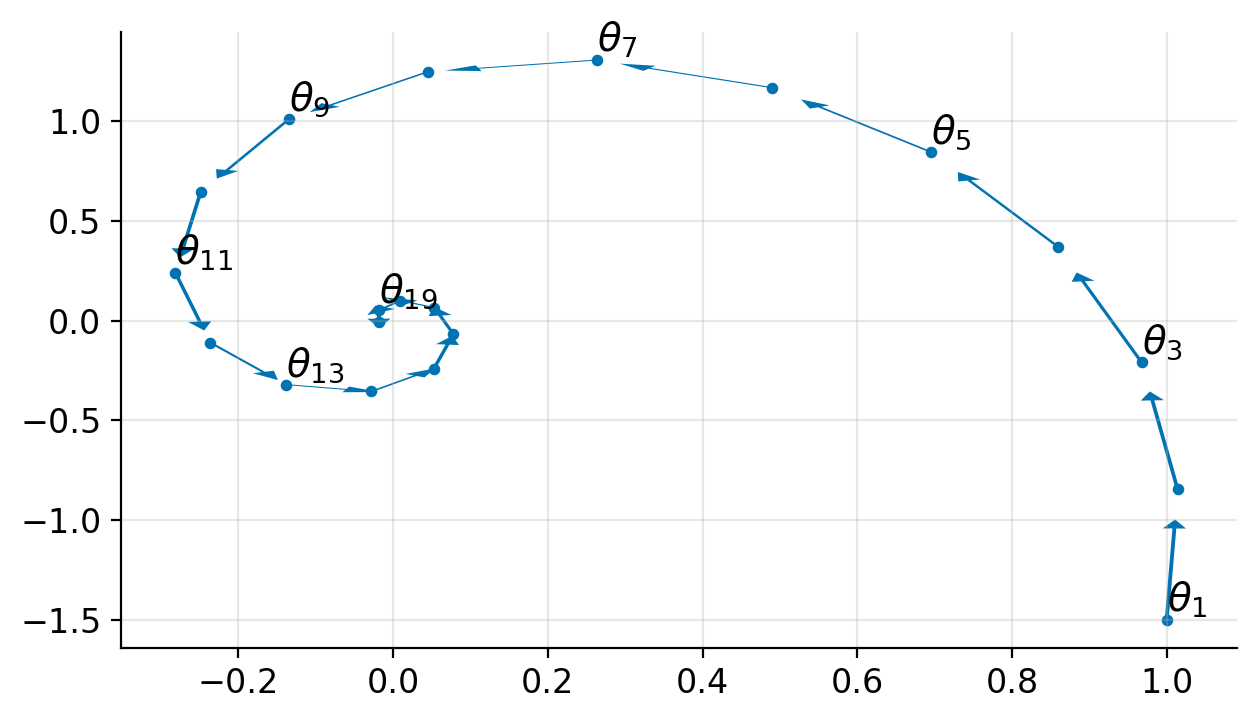

In [195]:
def f(x, t):
    x, y = x
    ẋ = -(x + y)
    ẏ = 6 * x - y
    return ẋ, ẏ
time = np.linspace(0, np.exp(3), 20)
time = np.exp(0.08163265) ** time
X = odeint(f, np.array([1.0, -1.5]), t=time)
plt.scatter(*X.T, s=10)

for i, (init, end) in enumerate(zip(X[:-1], X[1:])):
    Δx = end - init
    plt.arrow(*init, *Δx * 0.7, head_width=0.03, edgecolor="None", width=0.005)
    if i in [0, 2, 4, 6,8, 10, 12, 18]:
        plt.text(*init, r"$\theta_{"f"{i+1}""}$", horizontalalignment="left",
                 verticalalignment="bottom",
                 fontsize=14)
plt.grid(alpha=0.3)
# plt.savefig("../figures/discrete-dynamical-system.pdf")

## Coupled system

In [306]:
c0, c1 = sns.color_palette()[:2]

custom_lines = [
    Line2D([0], [0], color=c0, lw=2),
    Line2D([0], [0], color=c1, lw=2)
]

In [310]:
A = np.array([
    [-1, 1],
    [ -10, -1]
])

C = np.array([
    [-1, 0.],
    [-1.5, -1]
])

C = np.array([
    [1.0, 0.0],
    [0.0, 1.0]
])

# def hidden_process(X, t, A, C):
#     z = X[:2]
#     ż = A @ z
#     ẋ = C @ A @ z
#     return np.concatenate((ż, ẋ))

def hidden_process(X, t, A, C):
    z = X[:2]
    z = np.concatenate((z, z))
    zeros = np.zeros((2, 2))
    M = np.r_[np.c_[A, zeros],
              np.c_[zeros, C @ A]]
    return M @ z

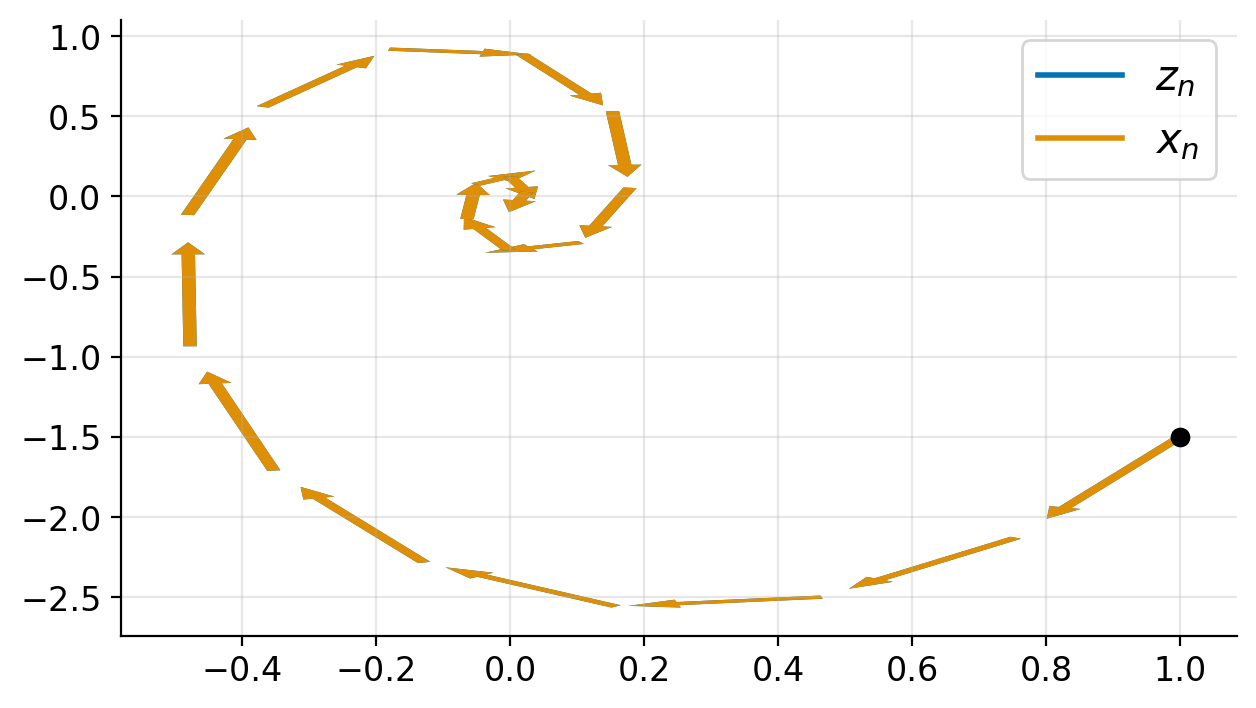

In [311]:
time = np.linspace(0, 3, 100)
steps = 20
time = np.linspace(0, np.exp(3), steps)
time = np.exp(0.08163265) ** time

X0 = np.array([1.0, -1.5, 1.0, -1.5])
X = odeint(hidden_process, X0, t=time, args=(A, C))
plt.plot(*X[[0]].T, marker="o", linewidth=0, c="black")

for n in range(steps - 1):
    Z0, X0 = X[n, :2], X[n, 2:]
    Z1, X1 = X[n + 1, :2], X[n + 1, 2:]
    Δx = X1 - X0
    Δz = Z1 - Z0
    plt.arrow(*Z0, *Δz * 0.7, head_width=0.05, edgecolor="None", width=0.02)
    plt.arrow(*X0, *Δx * 0.7, head_width=0.05, edgecolor="None", width=0.02, facecolor=c1)
    
plt.legend(custom_lines, ["$z_n$", "$x_n$"], prop={"size": 15}, loc="upper right")
plt.grid(alpha=0.3)
# plt.savefig("../figures/hidden-dynamical-system.pdf")

## Sampling

In [312]:
from scipy.stats import multivariate_normal

In [313]:
def kalman_bucy(z0, A, C, Γ, Σ, n_sims, n_steps, T):
    # Initial variables
    dt = T / n_steps
    m, *_ = z0.shape
    zeros = np.zeros((m, m))
    M = np.r_[np.c_[A, zeros],
              np.c_[zeros, C @ A]]
    cov = np.r_[np.c_[Γ, zeros],
                np.c_[zeros, Σ]]
    W = multivariate_normal(cov=cov)
    vn = np.concatenate((z0, z0))    
    sol = np.zeros((2 * m, n_sims, n_steps))
    
    vn = np.concatenate((z0, z0))[..., None] * np.ones((2 * m, n_sims))
    sol[:, :, 0] = vn
    for n in range(1, n_steps):
        dW = W.rvs(n_sims).T
        # vn + M * v + dW
        vhat_n = np.concatenate((vn[:2], vn[:2])) * np.ones((2 * m, n_sims))
        vn = vn + np.einsum("ij,js->is", M, vhat_n) * dt + dW * np.sqrt(dt)
        sol[:, :, n] = vn
    return sol

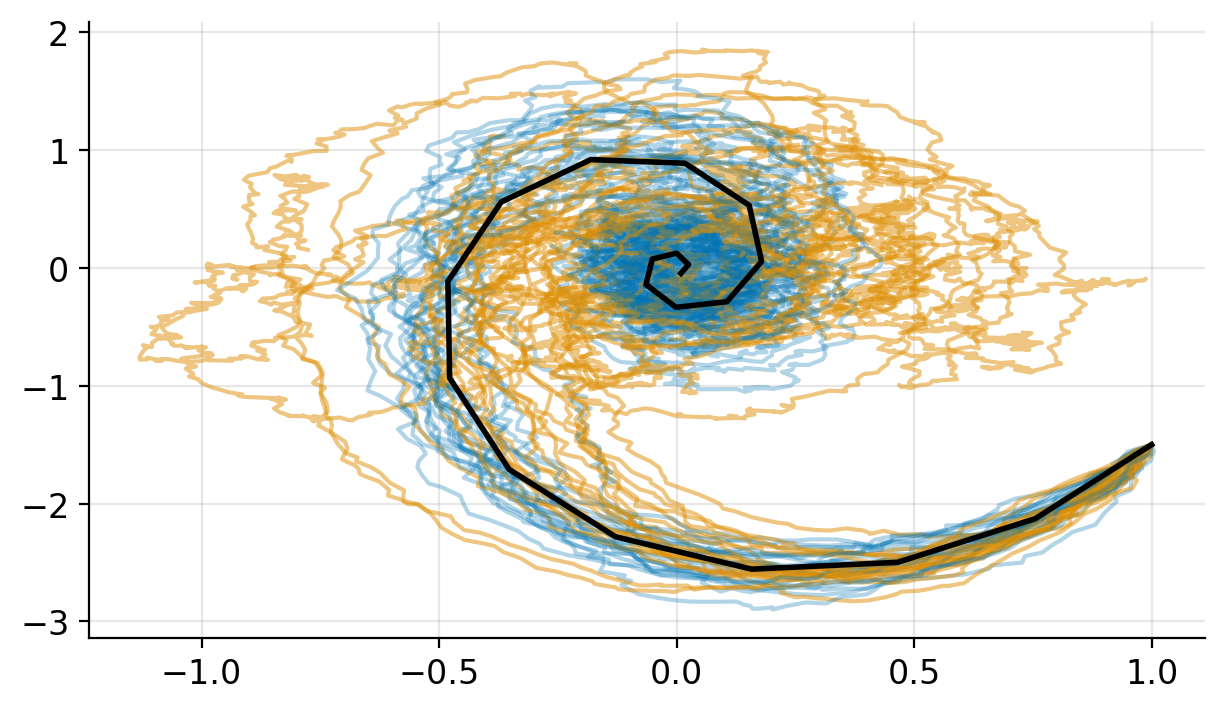

In [314]:

Γ = np.array([
    [0.4,  -0.8],
    [-0.1, 0.5]
])
Γ = Γ @ Γ.T / 5


Γ = np.eye(2) / 30
Σ = np.eye(2) / 50

muv = np.zeros(4)
zeros = np.zeros((2, 2))

z0 = np.array([1.0, -1.5])
np.random.seed(314)
n_sims, n_steps = 20, 500
T = 5
sol = kalman_bucy(z0, A, C, Γ, Σ, n_sims, n_steps, T)

plt.plot(*X[:, :2].T, c="black", linewidth=2, zorder=3)

for n in range(n_sims):
    plt.plot(sol[0, n, :], sol[1, n, :], c=c0, alpha=0.3)
    plt.plot(sol[2, n, :], sol[3, n, :], c=c1, alpha=0.5)

plt.grid(alpha=0.3)

## Sample

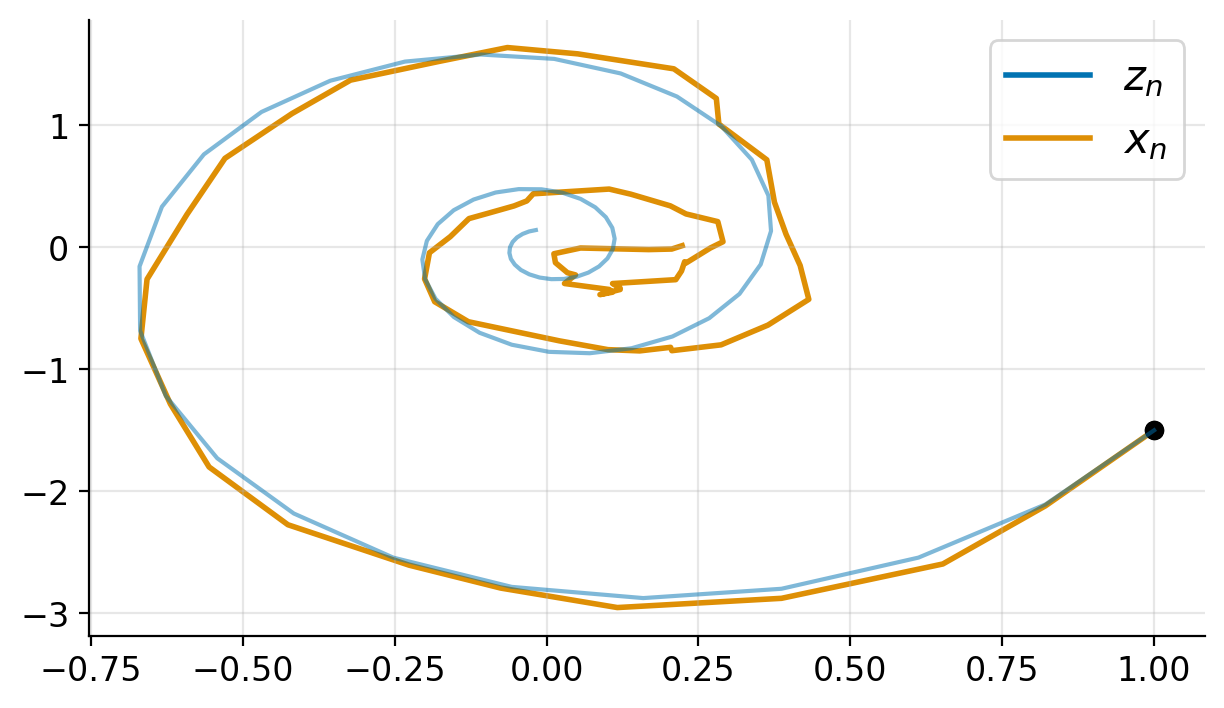

In [389]:
np.random.seed(11)
n_sims, n_steps = 10, 70
T = 5
sol = kalman_bucy(z0, A, C, Γ * 1e-5, Σ , n_sims, n_steps, T)
# The target simulation to show
s = 1
Xrand = sol[:, s, :].T
label_targets = [0, 2, 5, 10, 20, 45]

plt.plot(*Xrand[0].T, marker="o", linewidth=0, c="black")

for n in range(n_steps - 1):
    Z0, X0 = Xrand[n, :2], Xrand[n, 2:]
    Z1, X1 = Xrand[n + 1, :2], Xrand[n + 1, 2:]
    Δx = X1 - X0
    Δz = Z1 - Z0
    # plt.arrow(*Z0, *Δz * 0.7, head_width=0.08, edgecolor="None", width=0.025)
    # plt.arrow(*X0, *Δx * 0.7, head_width=0.08, edgecolor="None", width=0.025, facecolor=c1)

plt.plot(*Xrand[:, :2].T, c=c0, zorder=3, alpha=0.5)
plt.plot(*Xrand[:, 2:].T, zorder=0, color=c1, linewidth=2)
plt.legend(custom_lines, ["$z_n$", "$x_n$"], prop={"size": 15}, loc="upper right")
# plt.savefig("../figures/hidden-stochastic-dynamical-system.pdf")
plt.grid(alpha=0.3)